In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader

import numpy as np
from sklearn.model_selection import KFold

import argparse
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import math

## Preprocessing

In [2]:
df = pd.read_csv('datasets/train.csv')

df = df.drop('X_10', axis=1)
df = df.drop('X_11', axis=1)

x_df = df.iloc[:,1:55]

scaler = MinMaxScaler()

x_scale_df = scaler.fit_transform(x_df)
input_x = torch.tensor(x_scale_df)


In [3]:
input_x.size()

torch.Size([39607, 54])

In [4]:
test_df = pd.read_csv('datasets/test.csv')

test_df = test_df.drop('X_10', axis=1)
test_df = test_df.drop('X_11', axis=1)

x_test_df = test_df.iloc[:,1:55]

x_test_scale_df = scaler.fit_transform(x_test_df)
test_input_x = torch.tensor(x_test_scale_df)

In [5]:
class autoencoder(nn.Module):
    def __init__(self, input_size):
        super(autoencoder,self).__init__()
        self.input_size = input_size
        
        self.input_dim = self.input_size[1]
        
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim,(self.input_dim//4)*3),
            nn.SiLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear((self.input_dim//4)*3,self.input_dim),
            nn.SiLU()  
        )

    def forward(self,x):
        enc_output = self.encoder(x)
        y_hat = self.decoder(enc_output)
        return y_hat

    def get_encode(self, x):
        enc_output = self.encoder(x)
        return enc_output
    

In [6]:
class tableDataset:
    def __init__(self, data):
        self.data_ = data

    def __len__(self):
        return len(self.data_)

    def __getitem__(self, idx):
        data = self.data_[idx]
        X = data
        y = data

        return X, y  ## 데이터별 리스트


In [7]:
def train(train_data, Autoencoder, Autoencoder_optimizer, args): ## Data, loss function, argument
    trainloader = DataLoader(train_data, batch_size = args.batch_size, shuffle=True, drop_last=False)
    Autoencoder.train()

    train_loss = 0.0
    for i, (x,y) in enumerate(trainloader):

        Autoencoder_optimizer.zero_grad()
        x = x.float().to(args.device)
        y = y.float().to(args.device)

        y_hat= Autoencoder(x)

        loss = args.loss_fn(y_hat,y)

        loss.backward()

        Autoencoder_optimizer.step()## parameter 갱신

        train_loss += loss.item()

    train_loss = train_loss / len(trainloader)
    return Autoencoder, train_loss



# def test(test_data, Autoencoder, Autoencoder_optimizer, args): ## Data, loss function, argument
#     testloader = DataLoader(input_x, batch_size = args.batch_size, shuffle=True, drop_last=True)
#     Autoencoder.eval()

#     test_loss = 0.0
#     with torch.no_grad():
#         for i, (x,y) in enumerate(testloader):

#             y_hat, bottlenack_vec = Autoencoder(x)

#             perc_y_pred = y_hat.cpu().detach().numpy()
#             perc_y_true = y.cpu().detach().numpy()
#             mse = mean_squared_error(y_hat, y, multioutput='raw_values')[0]
#             rmse = math.sqrt(mse)   

#             RMSE_metric += rmse
#         RMSE_metric = RMSE_metric / len(testloader)
    
#     return RMSE_metric

In [8]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.optim = "NAdam"

args.batch_size = 128
args.lr = 0.0005
args.l2 = 0.00001

args.epoch = 100

args.loss_fn = nn.MSELoss()

In [9]:
input_size = input_x.size()

Autoencoder = autoencoder(input_size)
Autoencoder.to(args.device)


if args.optim == 'SGD':
    Autoencoder_optimizer = optim.SGD(Autoencoder.parameters(), lr=args.lr, weight_decay=args.l2)
elif args.optim == 'RMSprop':
    Autoencoder_optimizer = optim.RMSprop(Autoencoder.parameters(), lr=args.lr, weight_decay=args.l2)
elif args.optim == 'Adam':
    Autoencoder_optimizer = optim.Adam(Autoencoder.parameters(), lr=args.lr, weight_decay=args.l2)
elif args.optim == 'NAdam':
    Autoencoder_optimizer = optim.NAdam(Autoencoder.parameters(), lr=args.lr, weight_decay=args.l2)
else:
    raise ValueError('In-valid optimizer choice')



train_data = input_x

trainset = tableDataset(train_data)

train_losses = []
for epoch in range(args.epoch):

    Autoencoder,train_loss = train(trainset, Autoencoder, Autoencoder_optimizer, args)

    train_losses.append(train_loss)

    print('Epoch {}, Loss(train) {:2.5f}'.format(epoch, train_loss))

# last model save with state_dict()
torch.save(Autoencoder.state_dict(), 'autoencoder_output/Autoencoder_output' +'.pt')


Epoch 0, Loss(train) 0.04047
Epoch 1, Loss(train) 0.00999
Epoch 2, Loss(train) 0.00651
Epoch 3, Loss(train) 0.00464
Epoch 4, Loss(train) 0.00328
Epoch 5, Loss(train) 0.00245
Epoch 6, Loss(train) 0.00196
Epoch 7, Loss(train) 0.00162
Epoch 8, Loss(train) 0.00136
Epoch 9, Loss(train) 0.00116
Epoch 10, Loss(train) 0.00101
Epoch 11, Loss(train) 0.00090
Epoch 12, Loss(train) 0.00082
Epoch 13, Loss(train) 0.00075
Epoch 14, Loss(train) 0.00069
Epoch 15, Loss(train) 0.00064
Epoch 16, Loss(train) 0.00060
Epoch 17, Loss(train) 0.00056
Epoch 18, Loss(train) 0.00053
Epoch 19, Loss(train) 0.00050
Epoch 20, Loss(train) 0.00047
Epoch 21, Loss(train) 0.00045
Epoch 22, Loss(train) 0.00042
Epoch 23, Loss(train) 0.00040
Epoch 24, Loss(train) 0.00038
Epoch 25, Loss(train) 0.00037
Epoch 26, Loss(train) 0.00035
Epoch 27, Loss(train) 0.00034
Epoch 28, Loss(train) 0.00033
Epoch 29, Loss(train) 0.00031
Epoch 30, Loss(train) 0.00030
Epoch 31, Loss(train) 0.00030
Epoch 32, Loss(train) 0.00029
Epoch 33, Loss(train

## plot

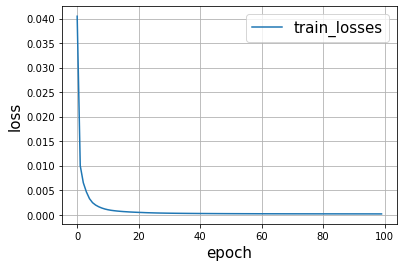

In [10]:
plt.plot(train_losses)
plt.legend(['train_losses'], fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.grid()

## Inference

In [12]:
Autoencoder = autoencoder(input_size)

#Autoencoder.to(args.device)

Autoencoder.load_state_dict(torch.load('autoencoder_output/Autoencoder_output' +'.pt'))


autoencoder_feature = Autoencoder.get_encode(input_x.float())

test_autoencoder_feature = Autoencoder.get_encode(test_input_x.float())


RuntimeError: Error(s) in loading state_dict for autoencoder:
	Unexpected key(s) in state_dict: "encoder.2.weight", "encoder.2.bias", "decoder.2.weight", "decoder.2.bias". 
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([39, 26]) from checkpoint, the shape in current model is torch.Size([54, 39]).
	size mismatch for decoder.0.bias: copying a param with shape torch.Size([39]) from checkpoint, the shape in current model is torch.Size([54]).

In [ ]:
np.save("autoencoder_feature",autoencoder_feature.detach().numpy())

np.save("autoencoder_feature_test",test_autoencoder_feature.detach().numpy())


torch.Size([39607, 26])
